# ASTR 596 Fall 2024 - Surface photometry lab (50 Points)

In this lab we will be performing surface photometry of four nearby galaxies, including ellipticals and spirals.  

This lab will be done via a mixture of python commands using the photutils aperture photometry package (https://photutils.readthedocs.io/en/stable/aperture.html) and the photutils isophote fitting package (https://photutils.readthedocs.io/en/stable/isophote.html).  We will also be using imexam and ds9.

In this lab you will learn how to do the following things:
* estimate the background for an image and subtract it;
* estimate initial guesses for input parameters to an isophotal fitting code using ds9;
* fit elliptical isophotes;
* use photometry within these isophotes to measure the radial profile of various parameters;
* compute the radius within which half the total light is contained.  This is called the effective radius.

<i>Note: Enter in all code to the problems in the provided notebook cells. Questions to answer will be <b>bolded</b>.</i>  

All your answers should be entered in this notebook. Each student will need to hand in their own notebook by uploading it to GitHub following the instructions.

In the code places where you will need to put something or write your own code are specified by `#***************`  You will not get points for doing this unless explicitly noted.  Some of these things are just to make sure you are setting up your paths correctly.

**Due on <font color='red'>12/2 at Noon</font>** to be handed into the "Surface Photometry" assignment in <font color='red'>Module 8</font>.

You will need to download the raw data.  You can access it at <ul><a href=https://www.dropbox.com/t/3my6A650iw8hB85l> this dropbox link </a></ul>.  There are four galaxy images.  You will need to measure something from all of them.  The galaxies are:
* NGC 3982
* NGC 5198
* NGC 5985
* PCG 0997820

You should have a directory on your computer called `~/ASTR596/Data`.  You shoudl put the data there.

In [2]:
#import 
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.io import fits
import glob
import os
from scipy.stats import scoreatpercentile
import astropy.units as u
from scipy import stats

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import colors


from astropy.nddata import CCDData
#from ccdproc import ImageFileCollection, Combiner, combine
from ccdproc import wcs_project

### Some functions to display the images

In [4]:
def imdisplay(image, v1perc=10, v2perc=95, logscale=True):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    fig,ax = plt.subplots(figsize=(6,6))
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    print(v1,v2)
    if (logscale):
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
    else:
        im = ax.imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')
        
    cbar = fig.colorbar(im, ax=ax, fraction=0.04)
    cbar.ax.set_ylabel('counts')
    return fig,ax

In [5]:
def imdisplay2(image, v1perc=10, v2perc=95, logscale=True):
    '''
    display two copies of an image side-by-side
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    #this makes two horizontal figures 
    fig,axs = plt.subplots(1,2,figsize=(12,6))
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    print(f"v1 = {v1:5.2f}, v2 = {v2:5.2f}")
    if (logscale):
        #plot the two figures side by side
        im0 = axs[0].imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
        im1 = axs[1].imshow(nimage,cmap='gray_r',aspect='equal',norm=colors.LogNorm(vmin=v1,vmax=v2),origin='lower')
    else:
        im0 = axs[0].imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')
        im1 = axs[1].imshow(nimage,cmap='gray_r',aspect='equal',vmin=v1,vmax=v2,origin='lower')

    #plot colorbars for each subplot
    cbar0 = fig.colorbar(im0, ax=axs[0], fraction=0.04)
    cbar0.ax.set_ylabel('counts')
    cbar1 = fig.colorbar(im1, ax=axs[1], fraction=0.04)
    cbar1.ax.set_ylabel('counts')
    return fig,axs


In [6]:
#***************
#put your data directory here
datadir = 'C:/Python/ASTR596/Data/Surface_Photometry'
#datadir = '/home/grudnick/ASTR596/Data/Surface_Photometry'
os.chdir(datadir)

## Display the image in DS9

SAOimage DS9 is a popular and easy to use image viewer.  There are various tutorials at https://sites.google.com/cfa.harvard.edu/saoimageds9/documentation?authuser=0 .

Here is another third party tutorial https://astrobites.org/2011/03/09/how-to-use-sao-ds9-to-examine-astronomical-images/ 

In the following description I will refer to menu choices as those at the top of the screen or window.  I will refer to buttons as the double line of buttons right above where the image is displayed.  I will refer to sub buttons with **button1**->**button2**

1. In DS9 open `NGC3982-custom-image-r.fits`
2. Under the **scale** button choose **log** and **zscale**.  In the Menu bar choose Scale->Scale parameters.  In the "high" box choose 3.
3. Use the right mouse button to change the stretch on the image.  You may need to select the **edit**->**none** or **edit**->**colorbar** button for this to work.


## Problem 1 - Estimate the background and subtract it (10 Points)

Before performing photometry you need to subtract off the background.  To do this for this exercise you are going to:
1. pick a square region in each of the 4 corners of the image and compute the best estimate of the background level over all the pixels in these areas.  Note that the straight average may not be the best option.
2. subtract this background level from the image 
3. display the background subtracted image

#### 1. compute background level
Here is an example of how to display an image with a log scaling.

10.19071102142334 11.842433891296398


Text(0.5, 1.0, 'NGC3982-custom-image-r.bkg.fits')

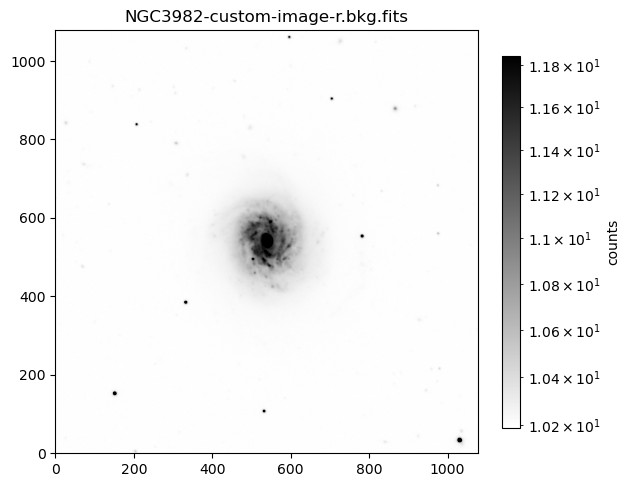

In [10]:
imname = 'NGC3982-custom-image-r.bkg.fits'
#fig,ax = plt.subplots(figsize=(6,6))
data,header = fits.getdata(imname, header=True)
fig,ax = imdisplay(data,v1perc=1,v2perc=99.9,logscale=True)

plt.title(imname)

This is a code that will take in an image name and data, as well as corners of background boxes, and will measure the background in two different ways.

In [12]:
def background_meas(imname,data,header,fig,ax,corners,bkg_size=5):
    #need to find ways to select regions of pixels in image
    fig,ax = imdisplay(data,v1perc=1,v2perc=99,logscale=True)

    plt.title(imname)

    #print out the x and y-dimension of the image using the header keywords
    print('image xdim = ', header['NAXIS1'], '; image ydim = ',header['NAXIS2'])
    #the length of each background box size
    #bkg_size = 200

    #make an array whose elements are the different data sections.
    reg = np.array([])


    #specify the different regions.  Each will be appended to the reg array.  the reg array is therefore 3 dimensional.  
    #the first dimension is for each region.  Each of those dimensions contains a 2D array that holds the image section.
    reg = np.append(reg, data[corners[0][0]:bkg_size-1, corners[0][1]:bkg_size-1])    #lower left corner
    reg = np.append(reg, data[corners[1][0]:bkg_size-1, corners[1][1]:])    #upper left corner
    reg = np.append(reg, data[corners[2][0]:, corners[2][1]:])    #upper right corner
    reg = np.append(reg, data[corners[3][0]:, corners[3][1]:bkg_size-1])   #lower right corner

    #print the median and mode of all the pixels. 
    bkgmode =stats.mode(reg,keepdims=False)[0]
    bkgmed = np.median(reg)
    print('mode = ',bkgmode)
    print('median = ',bkgmed)

    #Overlay rectangles with the background region indicated
    rectlist = []
    #loop through all images 
    for corn in corners:
        rect = plt.Rectangle((corn),bkg_size, bkg_size,linewidth=2,angle=0.0)
        rectlist.append(rect)
        pc = PatchCollection(rectlist,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_collection(pc)
        
    return bkgmode,bkgmed


Open the image in ds9 and use the log stretch to see if you can define corners of the image that are relatively free of galaxy light at a hard stretch.  You will compute the average pixel value in each of these regions and take the average.  It is ok if there are stars in these regions.  You should have 4 regions for the image.  An example that works for this image is shown below.  

**Note**
* to make it simpler, the boxes should be equal in size.  You will need to specify the lower left corner of each box.
* The images I am providing here have been selected from much larger images from the DESI Legacy Survey https://www.legacysurvey.org/viewer .  Therefore they do not have strange behavior around the edges and you can use the edges of the image as the edges of your sky region without any buffer region.

To make your coding easier, I'm going to make a bunch of dictionaries such that the main variable name is the same and you only have to change the galaxy name with the galname variable.

In [15]:
#initialize dictionaries that contains names of images and headers
imname = {}
data = {}
header = {}
corners = {}
bkgdim = {}

#statistics of background
bkgmode = {}
bkgmed = {}

In [16]:
#a routine to plot the images with the background measurement corners shown in red
def bkgregplot(data,header,imname, bkgdim, fig, ax):
    #define lower-left corners of each region
    corners = []
    corners.append([0,0])
    corners.append([0,header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim, header['NAXIS2']-bkgdim])
    corners.append([header['NAXIS1']-bkgdim,0])

    #run the background_meas code to measure the background and plot the background regions
    bkgmode,bkgmed = background_meas(imname, data, header, fig, ax, 
                                                       corners,bkg_size=bkgdim)
    return bkgmode, bkgmed

### NGC3982

10.19071102142334 10.892627716064453
image xdim =  1079 ; image ydim =  1079
mode =  10.198768615722656
median =  10.20020866394043


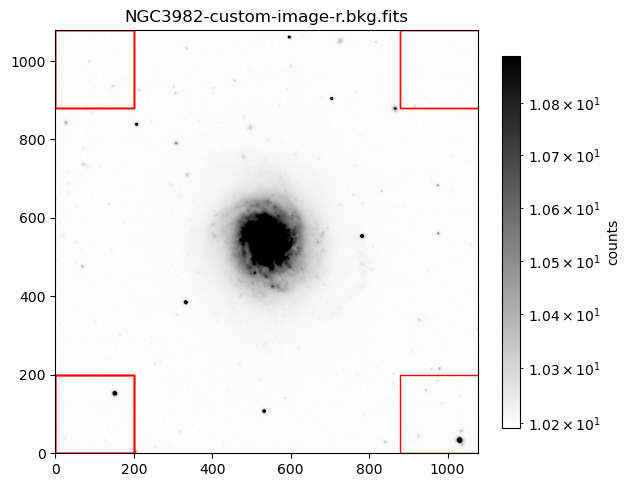

In [18]:
galname = 'NGC3982'
imname[galname] = 'NGC3982-custom-image-r.bkg.fits'

#read fits image
data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
bkgdim[galname]= 200

#plot image with background regions
bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)


### NGC5198

5.3430326461792 5.763217258453368
image xdim =  1131 ; image ydim =  1131
mode =  5.350897789001465
median =  5.34993314743042


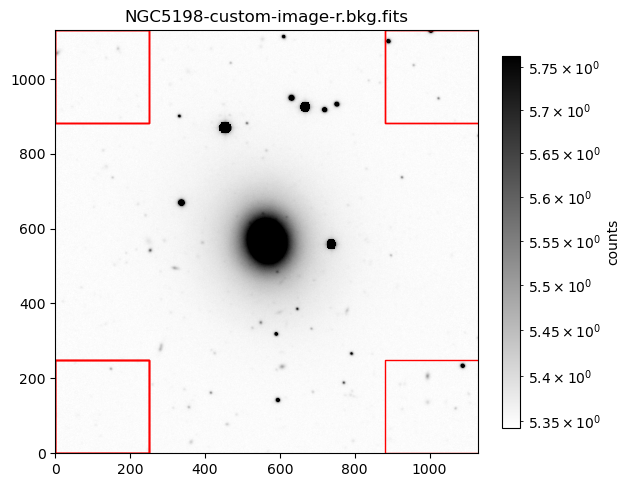

In [20]:
#*******************
#write your code here

galname = 'NGC5198'
imname[galname] = 'NGC5198-custom-image-r.bkg.fits'

#read fits image
data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
#this galaxy is smaller so i expanded the background boxes a little
bkgdim[galname]= 250

#plot image with background regions
bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)


### NGC5985

22.116252899169922 22.362007522583006
image xdim =  2291 ; image ydim =  2291
mode =  22.122928619384766
median =  22.122970581054688


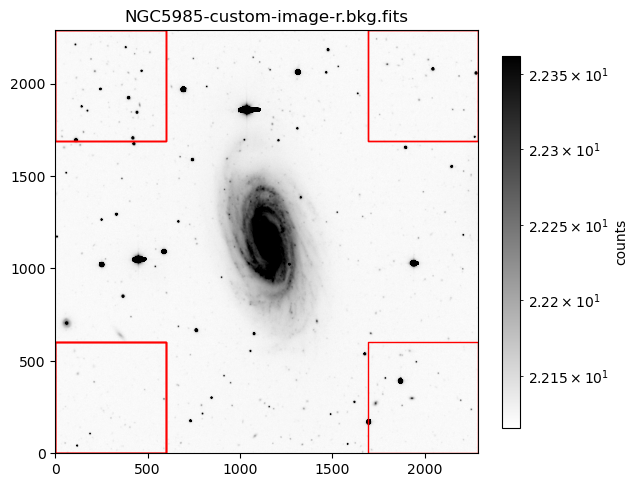

In [22]:
#*******************
#write your code here

galname = 'NGC5985'
imname[galname] = 'NGC5985-custom-image-r.bkg.fits'

#read fits image
data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
#the scale on this one is much larger than the other two
#additionally, the galaxy is very tilted
#so the clear background boxes are pretty big
bkgdim[galname]= 600

#plot image with background regions
bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

### PCG0997820

5.341621627807617 5.481662235260011
image xdim =  403 ; image ydim =  403
mode =  5.348475933074951
median =  5.3502068519592285


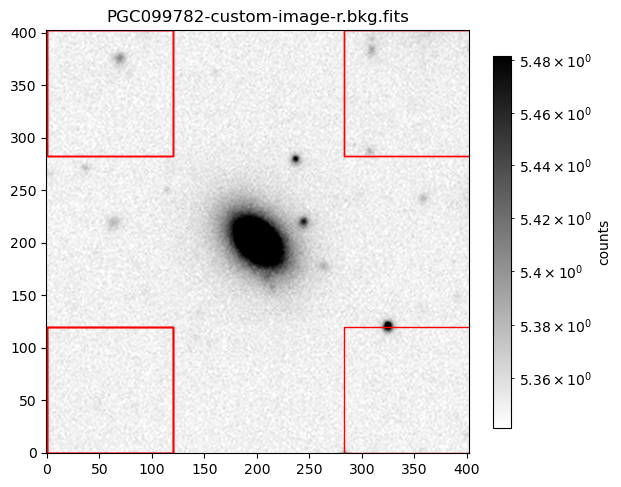

In [24]:
#*******************
#write your code here

galname = 'PGC0997820'
imname[galname] = 'PGC099782-custom-image-r.bkg.fits'

#read fits image
data[galname],header[galname] = fits.getdata(imname[galname], header=True)

#the size of the background squares
#this image is smaller than the others in pixels
#120 is the largest i could comfortably get without entering into the
# galaxy's glow interference
bkgdim[galname]= 120

#plot image with background regions
bkgmode[galname],bkgmed[galname] = bkgregplot(
    data[galname], header[galname], imname[galname], bkgdim[galname], fig, ax)

#### 2. subtract background and display subtracted image

In this component you will need to:
* subtract your background from the previously read in image
* display that image
* write out your image

I provide one example below and you will need to do the other 3.  Note that since counts can be negative, you will need to choose v1perc to make sure that the lowest counts are positive.  The limits of the colorbar scale are printed after the imdisplay() command so you will see how far you are away.

In [26]:
#initializse dictionary that will hold background subtracted images
data_bsub = {}
imname_bsub = {}

### NGC 3982

8.296966552734375e-05 1.6422252273559677


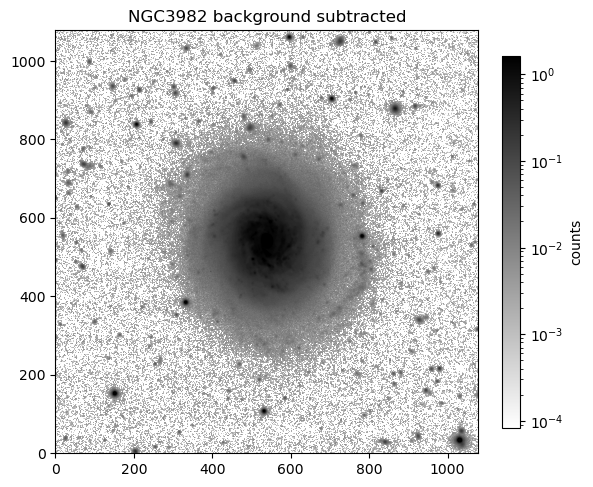

In [28]:
galname = 'NGC3982'

#background subtract the data
data_bsub[galname] = data[galname] - bkgmed[galname]

#display the background subtracted data
fig,ax =imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)

#add an image title
plt.title(galname + ' background subtracted')

#make a new image name that replaces one string with another
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")

# save the background_subtracted image to a file
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### NGC 5198

0.0003676414489746094 10.000036239624023


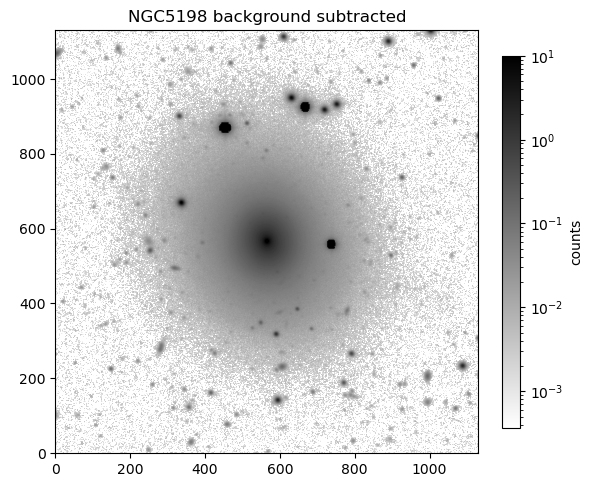

In [30]:
#***************
#your code goes here

galname = 'NGC5198'

#background subtract the data
data_bsub[galname] = data[galname] - bkgmed[galname]

#display the background subtracted data
#adjusted v1perc in intervals of 5 to get the smallest that produced no negatives
fig,ax =imdisplay(data_bsub[galname],v1perc=35,v2perc=99.9,logscale=True)

#add an image title
plt.title(galname + ' background subtracted')

#make a new image name that replaces one string with another
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")

# save the background_subtracted image to a file
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### NGC 5985

0.0002117156982421875 10.000011444091797


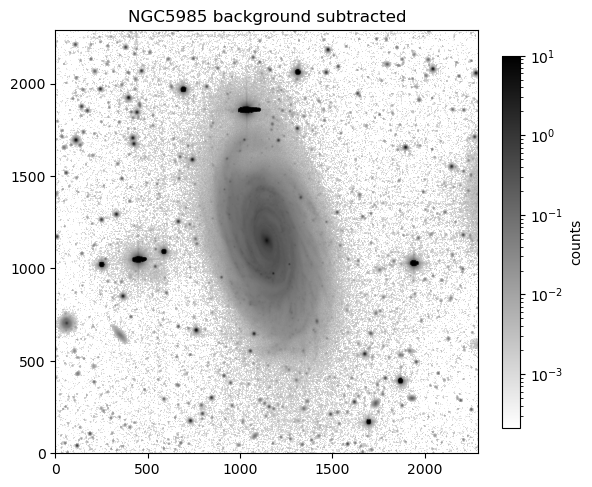

In [32]:
#***************
#your code goes here

galname = 'NGC5985'

#background subtract the data
data_bsub[galname] = data[galname] - bkgmed[galname]

#display the background subtracted data
#adjusted v1perc in intervals of 5 to get the smallest that produced no negatives
fig,ax =imdisplay(data_bsub[galname],v1perc=40,v2perc=99.9,logscale=True)

#add an image title
plt.title(galname + ' background subtracted')

#make a new image name that replaces one string with another
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")

# save the background_subtracted image to a file
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

### PGC 0997820

0.00015115737915039062 0.674437370300297


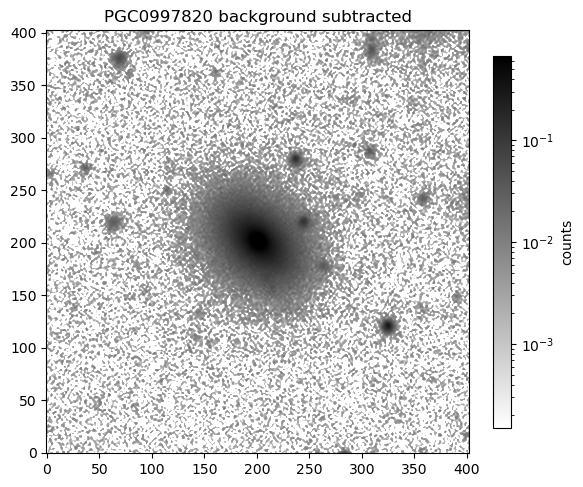

In [34]:
#***************
#your code goes here

galname = 'PGC0997820'

#background subtract the data
data_bsub[galname] = data[galname] - bkgmed[galname]

#display the background subtracted data
#adjusted v1perc in intervals of 5 to get the smallest that produced no negatives
fig,ax =imdisplay(data_bsub[galname],v1perc=45,v2perc=99.9,logscale=True)

#add an image title
plt.title(galname + ' background subtracted')

#make a new image name that replaces one string with another
imname_bsub[galname] = imname[galname].replace("bkg.fits","bsub.fits")

# save the background_subtracted image to a file
fits.writeto(imname_bsub[galname],data_bsub[galname],overwrite=True,header=header[galname])

**Question**: comment on the differences between the images with background and those with background subtracted.  Please describe why you think this is.

**put answer here.**

By subtracting the background, you're able to view the features of the galaxy and better confirm its edges.

Regarding the edges, in the original picture, the galaxy gradually fades into the background. In the background-subtracted image, there's more of a sharp edge because the galaxy is breaking off into nothing.

Regarding the features, the situation is similar. By scale stretching the original image, you can view various features by highlighting local minima and maxima. Subtracting the background allows you to see all features at the same scaling because the divides are clearer.

## Problem 2 - estimate initial guesses for ellipse parameters (15 Points)
The `photutils` package that we will be using for doing our photometry requires initial guesses for the center, semi-major axis, ellipticity, and position angle.  We will measure these using DS9 on the background subtracted images.
* xcen, ycen: What you think the center is by using the cursor on ds9

* semi-major axis, ellipticity, PA: For the other items you will need to make an elliptical region in ds9 that matches where the brighter part of the galaxy is.  If you double click on the region it will bring up a dialog box that lets you adjust the PA and also will output the semi-major and semi-minor axes, which you will need for the ellipticity measurement.  You should display the information in pixels using the dropdown to the right of the `radius` field in the "Ellipse" window.  Choose `Image`

**Note**: In ds9, when the first radius in the `Ellipse` window is the semi-major axis, the PA is measured South of East.  This is the same sense as the Elliptical Isophote package in the following problem uses.

For each galaxy, provide these intial guesses.  I will be storing these as a python dictionary for each galaxy.

These guesses do not need to be super precise but they need to be in the right ballpark.

In [38]:
#initialize the dictionary containing the intial parameters for the ellipse fitting
initparams = {}

#### NGC 3982

In [40]:
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC3982'
initparams[galname] = {}
#centroids [pixels]
initparams[galname]['xcen'] = 541
initparams[galname]['ycen'] = 541
#semi-major axis [pixels]
initparams[galname]['sma'] = 116
#semin-minor axis [pixels]
initparams[galname]['smina'] = 96
#ellipticity = 1-b/a
initparams[galname]['ellip'] = 1. - initparams[galname]['smina'] / initparams[galname]['sma'] 
#added a print for the ellipticity to reference it later
print('Ellipticity ',initparams[galname]['ellip'])
#position angle, counterclockwise from the positive x-direction (right) [degrees]
initparams[galname]['PA'] = 90.0

Ellipticity  0.1724137931034483


#### NGC 5198

In [42]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5198'
initparams[galname] = {}
#centroids [pixels]
#given that these images are centered on the galaxies,
# these values should always be the same
initparams[galname]['xcen'] = 566
initparams[galname]['ycen'] = 566
#based on the given example, the actual galaxy for this one is quite small
#with a very large surrounding region of glow
#semi-major axis [pixels]
initparams[galname]['sma'] = 30
#semin-minor axis [pixels]
initparams[galname]['smina'] = 25
#ellipticity about the same as the first galaxy
#ellipticity = 1-b/a
initparams[galname]['ellip'] = 1. - initparams[galname]['smina'] / initparams[galname]['sma'] 
#added a print for the ellipticity to reference it later
print('Ellipticity ',initparams[galname]['ellip'])
#position angle, counterclockwise from the positive x-direction (right) [degrees]
initparams[galname]['PA'] = 110

Ellipticity  0.16666666666666663


#### NGC 5985

In [44]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'NGC5985'
initparams[galname] = {}
#centroids [pixels]
initparams[galname]['xcen'] = 1144
initparams[galname]['ycen'] = 1144
#semi-major axis [pixels]
#a little uncertain about the dimensions of this one due to its prominent arms
initparams[galname]['sma'] = 305
#semin-minor axis [pixels]
initparams[galname]['smina'] = 161
#substantially more flattened than the first two, matching visual inspection
#ellipticity = 1-b/a
initparams[galname]['ellip'] = 1. - initparams[galname]['smina'] / initparams[galname]['sma'] 
#added a print for the ellipticity to reference it later
print('Ellipticity ',initparams[galname]['ellip'])
#position angle, counterclockwise from the positive x-direction (right) [degrees]
initparams[galname]['PA'] = 100

Ellipticity  0.4721311475409836


PGC 0997820

In [46]:
#*******************
#Your estimates go here.
#initiparams is a dictionary which contains an entry for each galaxy.  That dictionary in turns points to another dictionary with the parameters.
galname = 'PGC0997820'
initparams[galname] = {}
#centroids [pixels]
initparams[galname]['xcen'] = 202
initparams[galname]['ycen'] = 202
#semi-major axis [pixels]
#about the same pixel size as the second galaxy
initparams[galname]['sma'] = 31
#semin-minor axis [pixels]
initparams[galname]['smina'] = 21
#ellipticity = 1-b/a
#a middling ellipticity between the others
initparams[galname]['ellip'] = 1. - initparams[galname]['smina'] / initparams[galname]['sma'] 
#added a print for the ellipticity to reference it later
print('Ellipticity ',initparams[galname]['ellip'])
#position angle, counterclockwise from the positive x-direction (right) [degrees]
initparams[galname]['PA'] = 140

Ellipticity  0.32258064516129037


## Problem 3 - fit elliptical isophotes and measure the radial profiles for various ellipse paramters (15 Points)

We will now use the `photutils.isophot()` task to fit elliptical isophotes (https://photutils.readthedocs.io/en/stable/isophote.html).  An "isophote" is a line of constant surface brightness, akin to a countour on a topographical map.  To get a visual representation of an isophote do the following:
* open one of the background subtracted images in ds9 and dislay it in log scale
* in the analysis menu open "contour parameters" and set the number of countours to 10.  Then hit `Generate` and then `Apply`

The green lines on your image connect pixels of identical flux.  Since the pixels have the same area within a given image, these lines therefore connect points of constant surface brightness.

The `photutils.isophote()` code that we will be using fits ellipses to the isophotes.

In [48]:
from photutils.isophote import EllipseGeometry
from photutils.aperture import EllipticalAperture

#define an empty dictionary that will contain the EllipseGeometry instance
geometry = {}

 We must provide the elliptical isophote fitter with an initial ellipse to be fitted. This ellipse geometry is defined with the **EllipseGeometry** class. Here we’ll define an initial ellipse from our answer to problem 2.

### NGC 3982

116 0.1724137931034483
8.296966552734375e-05 6.612554946894021


Text(0.5, 1.0, 'NGC3982')

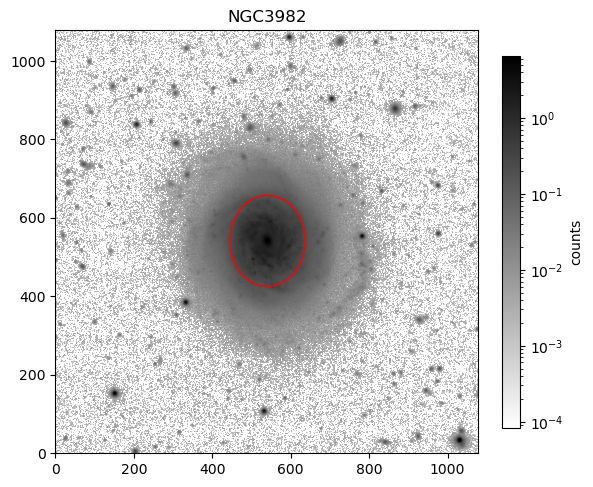

In [51]:
#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC3982'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

print(geometry[galname].sma,geometry[galname].eps )
#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (1.-geometry[galname].eps), geometry[galname].pa)

#plot our image
#fig,ax = plt.subplots(figsize=(6,6))
fig,ax = imdisplay(data_bsub[galname],v1perc=40,v2perc=99.99,logscale=True)
aper.plot(color='red')
plt.title(galname)

### NGC 5198

30 0.16666666666666663
0.0003676414489746094 10.000112533569336


Text(0.5, 1.0, 'NGC5198')

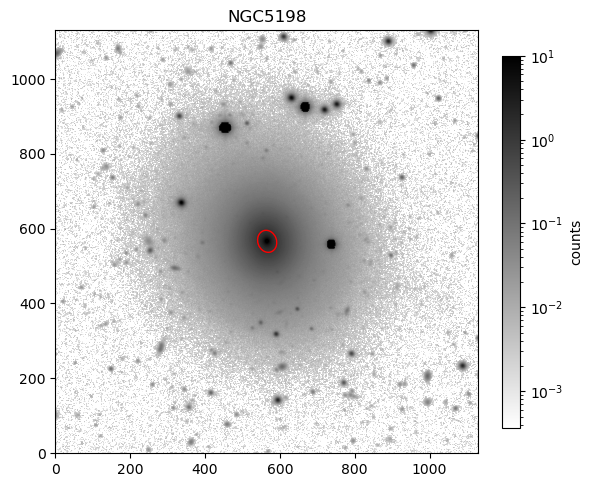

In [53]:
#***************************
#Your code here

#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5198'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

print(geometry[galname].sma,geometry[galname].eps )
#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (1.-geometry[galname].eps), geometry[galname].pa)

#plot our image
#fig,ax = plt.subplots(figsize=(6,6))
#replacing given v1perc with the one selected above
fig,ax = imdisplay(data_bsub[galname],v1perc=35,v2perc=99.99,logscale=True)
aper.plot(color='red')
plt.title(galname)

### NGC 5985

305 0.4721311475409836
0.0002117156982421875 10.000072479248047


Text(0.5, 1.0, 'NGC5985')

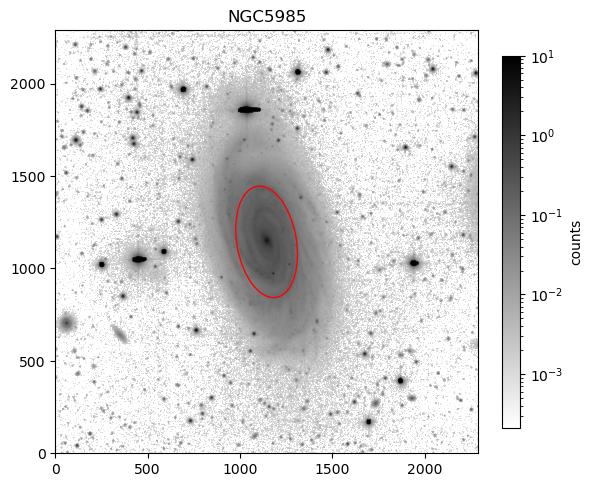

In [55]:
#***************************
#Your code here

#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'NGC5985'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

print(geometry[galname].sma,geometry[galname].eps )
#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (1.-geometry[galname].eps), geometry[galname].pa)

#plot our image
#fig,ax = plt.subplots(figsize=(6,6))
#replacing given v1perc with the one selected above
#tho for this one it's the same (40)
fig,ax = imdisplay(data_bsub[galname],v1perc=40,v2perc=99.99,logscale=True)
aper.plot(color='red')
plt.title(galname)

### PGC 0997820

31 0.32258064516129037
0.00015115737915039062 1.2189745571135244


Text(0.5, 1.0, 'PGC0997820')

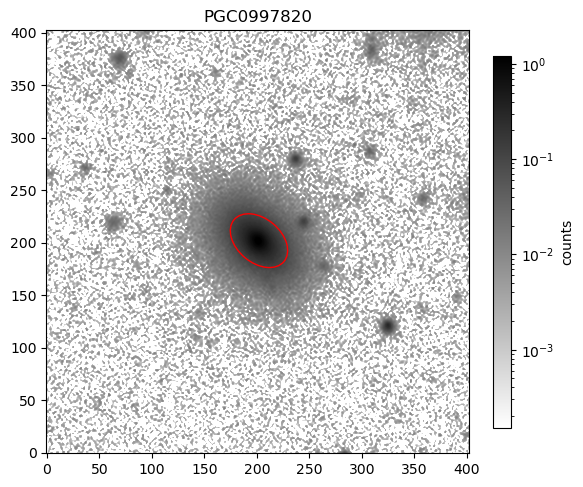

In [57]:
#***************************
#Your code here

#set up the EllipseGeometry instance with the right initial guess parameters
galname = 'PGC0997820'
geometry[galname] = EllipseGeometry(x0 = initparams[galname]['xcen'], 
                                      y0 = initparams[galname]['ycen'],
                                      sma = initparams[galname]['sma'],
                                      eps = initparams[galname]['ellip'],
                                      pa = initparams[galname]['PA'] * np.pi/180)   #convert into radians

print(geometry[galname].sma,geometry[galname].eps )
#make an aperture to overplot so that we can check if it makes sense
aper = EllipticalAperture((geometry[galname].x0, geometry[galname].y0), geometry[galname].sma, 
                          geometry[galname].sma * (1.-geometry[galname].eps), geometry[galname].pa)

#plot our image
#fig,ax = plt.subplots(figsize=(6,6))
#replacing given v1perc with the one selected above
#this one will specifically not run at default 40
fig,ax = imdisplay(data_bsub[galname],v1perc=45,v2perc=99.99,logscale=True)
aper.plot(color='red')
plt.title(galname)

**Question** For some of these galaxies, the PA is very important to get the apertures right.  Please tell me for which galaxies it is not very important, and why.

**put answer in this cell**

PA rotates the galaxy relative to the observer. This won't matter for galaxies that appear circular, since rotating a circle changes nothing. [UPDATE NUMBERS, THESE ARE INCORRECT] All four galaxies in this set have substantial ellipticity, with the lowest being about 1.2; if a galaxy had an ellipticity that was nearly 1.0, PA wouldn't change anything (and would be hard to guess at anyway). In some of these printed images, the first two galaxies (NGC3982 and NGC5198) appear pretty circular, but by adjusting the scaling in DS9, more angled features become apparent. In terms of more physical properties, a galaxy with very low ellipticity would be a flat galaxy viewed from the top or bottom, or a nearly spherical galaxy viewed from any angle.

#### Some routines I wrote for you for the next parts
This is a subroutine I have written to plot our outputs of ellipse fitting

In [61]:
def plotellipse(isolist):
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(hspace=0.35, wspace=0.35)

    #plot the semi-major axis vs. the ellipticity
    plt.subplot(2, 2, 1)
    plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
                 fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('Ellipticity')

    #plot the semi-major axis vs. the PA
    plt.subplot(2, 2, 2)
    plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.0,
                 yerr=isolist.pa_err / np.pi * 80.0, fmt='o', markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('PA (deg)')

    #plot the semi-major axis vs. the x center of that ellipse
    plt.subplot(2, 2, 3)
    plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('x0')

    #plot the semi-major axis vs. the y center of that ellipse
    plt.subplot(2, 2, 4)
    plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
                 markersize=4)
    plt.xlabel('Semimajor Axis Length (pix)')
    plt.ylabel('y0')

This is a subroutine to plot all of the ellipses.  It plots one version where the ellipse has a free geometry at every isophote and one where I set the ellipses to have the same geometry at every semi-major axis.

In [63]:
#this subroutine will plot every other isophote on top of the galaxy image
def plotaper(galname, image, isophote_list,vminperc=40,vmaxperc=99.99):

    #I added this adjustment because vminperc 40 doesn't work for galaxies where
    # the vminperc needed to be increased
    #which in this case was just this one, at 45
    if(galname=='PGC0997820'):
        vminperc=45
    
    #plot image
    #plt.subplots(figsize=(6,6))
    fig,ax = imdisplay2(image,v1perc=vminperc,v2perc=vmaxperc,logscale=True)

    #Loop through all apertures starting at the first (not zero) and going to every other aperture
    for i in range(1, len(isophote_list.sma),2):
        #create an elliptical aperture with the the correct geometry.  
        #Task is described here https://photutils.readthedocs.io/en/stable/api/photutils.aperture.EllipticalAperture.html#photutils.aperture.EllipticalAperture
        aperiter = EllipticalAperture((isophote_list.x0[i], isophote_list.y0[i]), isophote_list.sma[i], 
                                      isophote_list.sma[i] * (1-isophote_list.eps[i]), isophote_list.pa[i])
    
        #overplot apertures
        aperiter.plot(ax=ax[0],color='red')

    #plot the isophotes that have parameters fixed to the median parameters of all but the "apmin" inner isphotes
    #compute median isophote parameters ignoring inner isophotes.  This is because the inner isophotes all tend to be rather circular
    apmin = 20   #the minimum inner isophote in terms of isophote number.
    xcenav = np.median(isophote_list.x0[apmin:])
    ycenav = np.median(isophote_list.y0[apmin:])
    epsav = np.median(isophote_list.eps[apmin:])
    paav = np.median(isophote_list.pa[apmin:])
    
    #fig,ax = imdisplay(image,v1perc=vminperc,v2perc=vmaxperc,logscale=True)
    for i in range(1, len(isophote_list.sma),2):
        #create an elliptical aperture with the the correct geometry.  
        #Task is described here https://photutils.readthedocs.io/en/stable/api/photutils.aperture.EllipticalAperture.html#photutils.aperture.EllipticalAperture
        aperiter = EllipticalAperture((xcenav, ycenav), isophote_list.sma[i], 
                                      isophote_list.sma[i] * (1-epsav), paav)
    
        #overplot apertures
        aperiter.plot(ax=ax[1],color='blue')

    ax[0].set_title(galname + ' free ellipse parameters')
    ax[1].set_title(galname + ' fixed ellipse parameters')

    return xcenav, ycenav, epsav, paav

Next, we create an instance of the Ellipse class, inputting the data to be fitted and the initial ellipse geometry object:

In [65]:
from photutils.isophote import Ellipse

#initialize dictionary for ellipse fitting
ellipse = {}
isolist = {}

The values computed by the fitting process are the attributes at this table https://photutils.readthedocs.io/en/stable/api/photutils.isophote.Isophote.html#photutils.isophote.Isophote

I will do the first galaxy for you and you will need to do the other three

### NGC 3982

In [68]:
xcenav = {}
ycenav = {}
epsav = {}
paav = {}

In [69]:
#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC3982'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

[0.         0.51919334 0.51919334 0.5189809  0.46069269 0.27608592
 0.1579611  0.03241257 0.0612167  0.08055238 0.06302387 0.03588602
 0.05193213 0.05276046 0.05838631 0.06275593 0.06737938 0.07591232
 0.06136657 0.06754846 0.07130226 0.07238078 0.08106307 0.08522997
 0.10076086 0.11421118 0.13186718 0.14952019 0.16671638 0.18005525
 0.19495951 0.20713786 0.21792652 0.2269808  0.23111203 0.22612461
 0.22513992 0.22286505 0.22167769 0.21996118 0.24188552 0.32618964
 0.39333236 0.43795328 0.49207247 0.46880081 0.38838288 0.38838288
 0.42603435 0.45313677 0.21824228 0.24211621 0.29872629 0.12213135
 0.09631953 0.09631953 0.09865921 0.08157075 0.16569951 0.17238527
 0.09656132 0.08157075 0.08157075 0.08157075 0.08157075 0.08157075
 0.08157075 0.08157075]
v1 =  0.00, v2 =  6.61


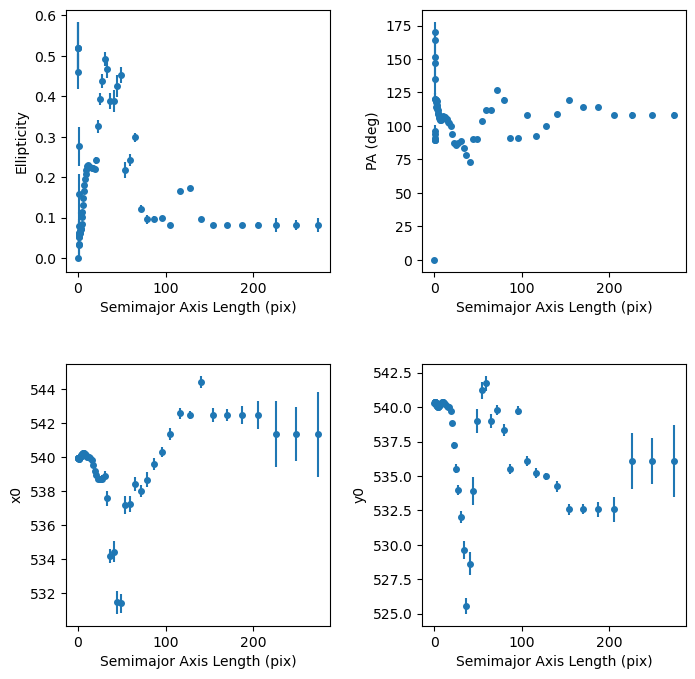

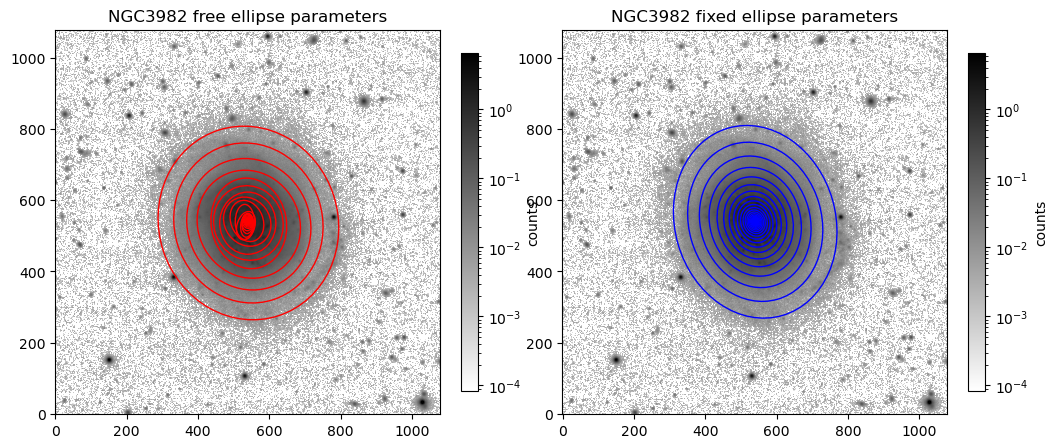

In [70]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].eps)

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])
#save the shape values of the average ellipse.  We will need this later for aperture photometry
xcenav[galname], ycenav[galname], epsav[galname], paav[galname] = plotaper(galname, data_bsub[galname],isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the images and the apertures, as viewed in the cells above or in ds9

**put answer in this cell**

What's generally going on is that successive ellipses are being drawn to describe the region within and around the galaxy in terms of light. Each plot's X axis is semimajor axis length, so each point is describing a successively larger ellipse.

The ellipticity plot starts out shaky due to a lack of information to work with, rapidly rises from 0 to 0.5 as it starts to pick up features of the galaxy, and settles to about 0.1 by the time it encompasses the actual galaxy at 116. After this, it's capturing the glow of the galaxy, which spreads smoothly. Because there's no need for consistency, as it traces the spirals it alters its ellipticity on either side of the assigned 0.17, starting out more extended and ending up more circular.

The PA plot starts out unsteady for the same reason. The ellipses rotate to either side a bit as they follow the spiraling features of the galaxy. Eventually they stabilize once they're in the region of the galaxy's smooth glow.

The x0 deviates a bit trying to fit undersized ellipses to the galaxy features but generally doesn't have much reason to move a lot. The final several values have low certainty because there aren't clear galaxy features that far out.

The y0 plot is about the same as the x0 plot, but it shifts more due to the galaxy occupying more y-space than x-space.

### NGC 5198

In [74]:
#***************************
#Your code here

#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC5198'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

[0.         0.30178331 0.2840466  0.29424538 0.20489821 0.00530109
 0.02797961 0.08001926 0.09361506 0.0847726  0.05573066 0.04352669
 0.03355541 0.03728464 0.0485523  0.06152706 0.05526762 0.05530453
 0.0469905  0.05422131 0.05326118 0.04872989 0.04542346 0.04538512
 0.04374558 0.04270914 0.04109646 0.04249872 0.04301015 0.04776649
 0.05201605 0.05828538 0.06572888 0.06960421 0.0719046  0.0893677
 0.10075683 0.11172669 0.12181967 0.13028972 0.1383347  0.14748926
 0.15723805 0.15723805 0.15701013 0.15958825 0.16276846 0.16056152
 0.15685821 0.15292461 0.14571966 0.13909942 0.14386627 0.13729516
 0.13679962 0.12586469 0.12138483 0.12255011 0.12907387 0.14542354
 0.14412422 0.14412422 0.14412422 0.14412422 0.14412422 0.14412422]
v1 =  0.00, v2 = 10.00


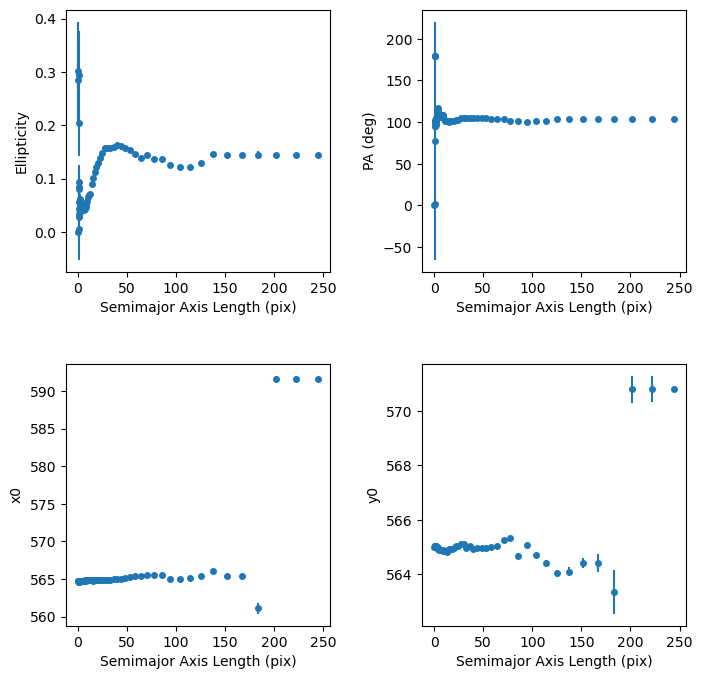

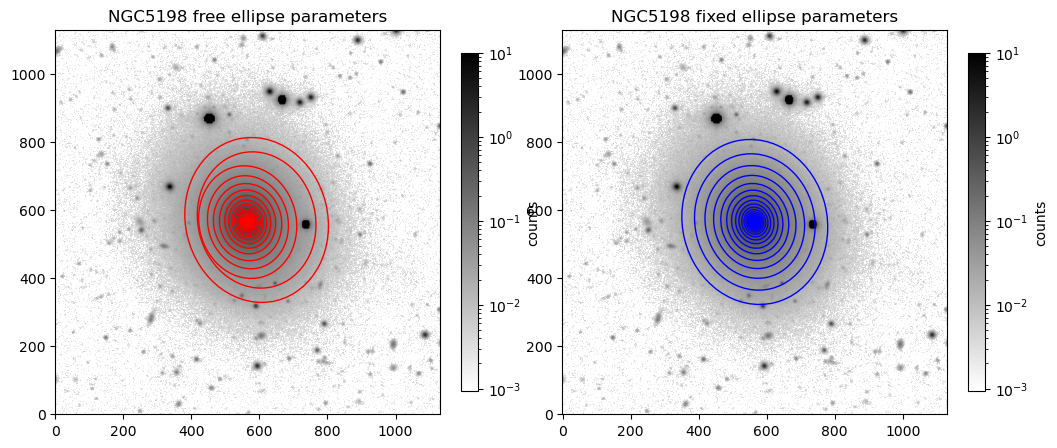

In [75]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].eps)

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])
#save the shape values of the average ellipse.  We will need this later for aperture photometry
xcenav[galname], ycenav[galname], epsav[galname], paav[galname] = plotaper(galname, data_bsub[galname],isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the images and the apertures, as viewed in the cells above or in ds9

**put answer in this cell**

This galaxy lacks the spirals of the previous one, so most of the values are a lot steadier as it spreads out smoothly.

Similar to the previous galaxy, ellipticity starts out low while capturing the even center of the galaxy, gets high as its notices the galaxy features, and reduces and stabilizes. For this one, the high value is nearly the same as the steady value due to the lack of complex features and the small size of the galaxy itself.

The final few values of x0 and y0 are severely shifted because the ellipses are trying to capture the very bright object to the +x of the galaxy. This is especially obvious when you compare the two images.

### NGC 5985

In [79]:
#***************************
#Your code here

#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'NGC5985'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

[0.         0.230522   0.22761585 0.22449222 0.22241451 0.21955429
 0.19500192 0.13410071 0.1265224  0.12576416 0.12434526 0.12395768
 0.1454806  0.16206022 0.1711614  0.1802518  0.17819914 0.19231093
 0.18410561 0.18208584 0.18205108 0.17292769 0.17682976 0.17114724
 0.17892028 0.18172867 0.18452086 0.18987228 0.19793887 0.20813838
 0.21574124 0.2245858  0.23321754 0.24348387 0.25531656 0.26314886
 0.27003355 0.27359246 0.2784143  0.28023685 0.28890017 0.3028409
 0.31869439 0.33465247 0.35686778 0.37162044 0.38136811 0.38879974
 0.40531747 0.41736556 0.43632692 0.44320899 0.44132872 0.36590305
 0.38232255 0.38232255 0.47301456 0.51626477 0.52674305 0.54585513
 0.47819479 0.47819479 0.68611117 0.59594856 0.49296686 0.48451308
 0.4634548  0.5256834  0.47819479 0.49684987 0.48849908 0.49733954
 0.51147286 0.51147286 0.51147286 0.51147286 0.51147286 0.51147286
 0.51147286 0.51147286]
v1 =  0.00, v2 = 10.00


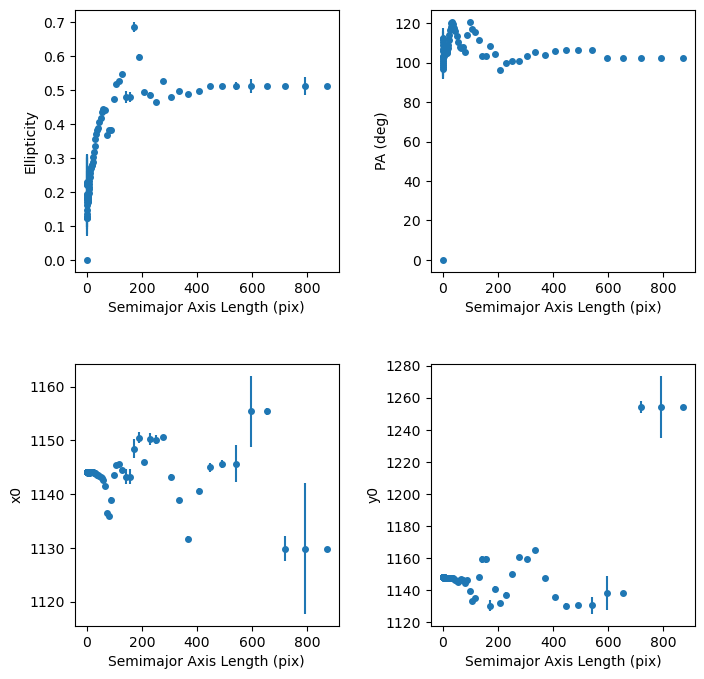

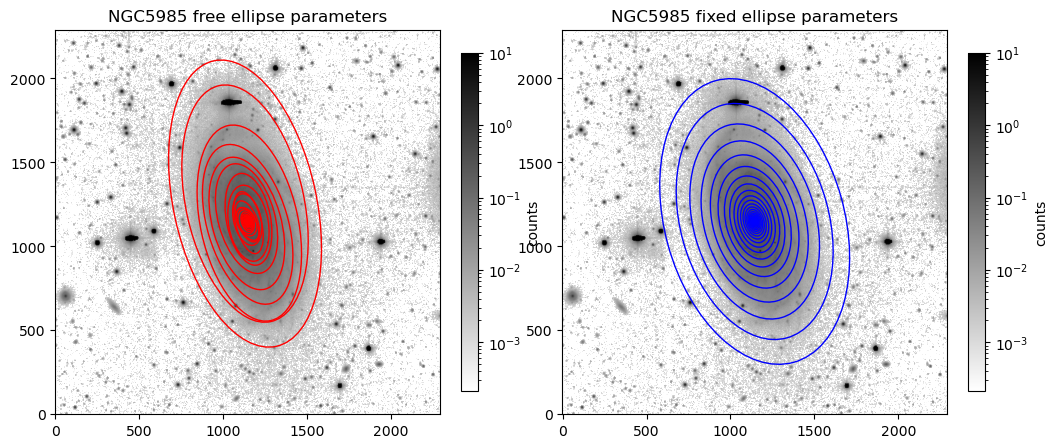

In [80]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].eps)

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])
#save the shape values of the average ellipse.  We will need this later for aperture photometry
xcenav[galname], ycenav[galname], epsav[galname], paav[galname] = plotaper(galname, data_bsub[galname],isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the images and the apertures, as viewed in the cells above or in ds9

**put answer in this cell**

The graphs for this galaxy act a lot like the ones for the first galaxy since they're both spirals. This galaxy is a lot more defined, both in terms of features and pixels, so there's less unsteadiness.

The ellipticity and PA rise as the ellipses trace the galaxy center extending into the arms, before reducing and stabilizing.

The galaxy center is difficult to pinpoint due to asymmetrical elements of the arms. The last few values are once again wrecked by the bright object to the +y of the galaxy.

### PGC 0997820

In [84]:
#***************************
#Your code here

#this will do the fitting of the isophotes by making an instance of the Ellipse class
#It then fits the data using the initial guesses we computed above
galname = 'PGC0997820'
ellipse[galname] = Ellipse(data_bsub[galname], geometry[galname])
isolist[galname] = ellipse[galname].fit_image()

[0.         0.06188596 0.05050284 0.04175365 0.01551172 0.06629233
 0.11182098 0.13241179 0.15205322 0.16692308 0.1691427  0.16557716
 0.15461758 0.14066738 0.13316538 0.13316538 0.12861277 0.14176772
 0.14038668 0.13998518 0.15033013 0.16133674 0.16688944 0.175008
 0.18670261 0.19753014 0.20412664 0.20483281 0.20124827 0.20268329
 0.20817646 0.21458882 0.22153841 0.22910678 0.2315492  0.24088454
 0.26132206 0.27461013 0.28907211 0.30162951 0.30969568 0.31637652
 0.32904215 0.32874185 0.33646058 0.32705562 0.33426192 0.32926773
 0.32354144 0.32010351 0.30171063 0.19068446 0.27012613 0.22683149
 0.22683149 0.15772182 0.15772182 0.15772182]
v1 =  0.00, v2 =  1.22


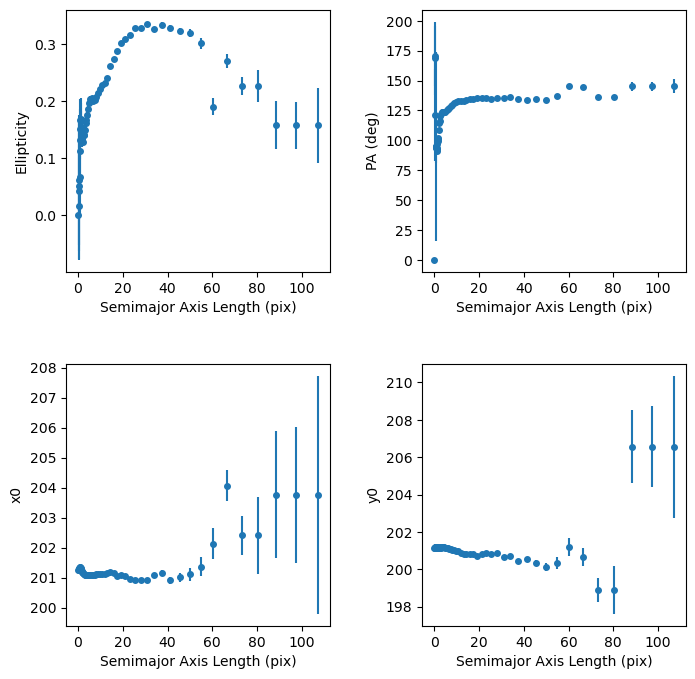

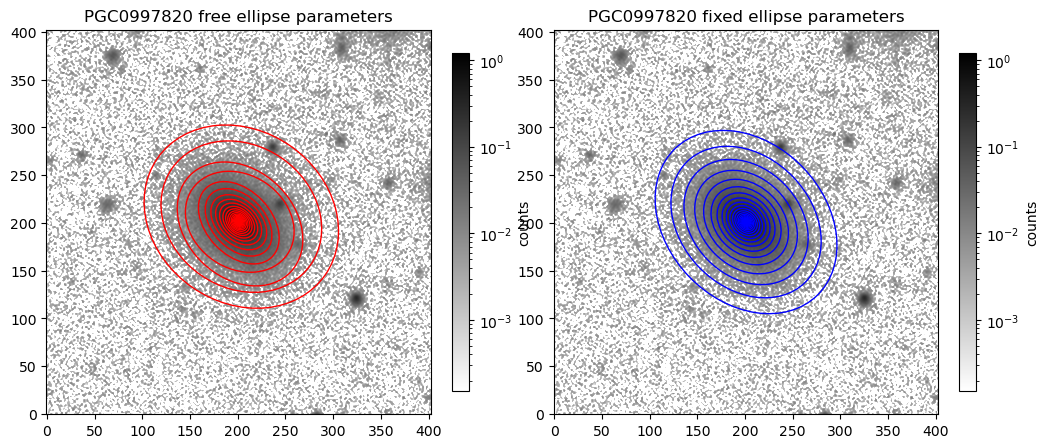

In [85]:
#this puts the output into a table containing every ellipse.   
#You can comment this first line out if you don't want it always to print out.
print(isolist[galname].eps)

#make a set of plots that show some attributes of every ellipse.
plotellipse(isolist[galname])
#save the shape values of the average ellipse.  We will need this later for aperture photometry
#note that I slightly modified plotaper to make it work with this galaxy
xcenav[galname], ycenav[galname], epsav[galname], paav[galname] = plotaper(galname, data_bsub[galname],isolist[galname])

**Question** Describe the behavior of each plot in words and how it relates to the images and the apertures, as viewed in the cells above or in ds9

**put answer in this cell**

This galaxy has less data to work with than the others, so the adjustments in the graphs are going to be more extreme.

The ellipticity follows the same trend as above - starting out low inside the galaxy, rising around the edge of the galaxy, and reducing to stability outside the galaxy.

The PA changes notably, rotating as the glow spreads outward. This is matched by visual investigation of the subtracted image - the core of the galaxy and the edges of the glow appear to have different rotations. This is likely due to either poor definition of the galaxy center or nearby objects contributing to the local background (or both).

x0 and y0 shift substantially due to the bright objects near the galaxy.

**Question** In light of the differences between the free ellipse geometry and the constrained ellipse geometry, discuss the advantages and disadvantages are of the two in regards to measuring the shape of the isophotes and in measuring the flux profiles.

**put answer in this cell**

One clear advantage of constrained geometry is that it's resistant to nearby bright objects, as seen above.

A disadvantage of constrained geometry is that it's heavily dependent on human judgment of the galaxy's characteristics. Some galaxies are much more difficult to personally parse. Free parameters handle these better by being able to consider several sets of points at once.

The free ellipse geometry's tracing effect can be both advantageous and disadvantageous. It's difficult to specify the exact edge of a galaxy, and free parameters allow you to consider and compare several potential edges. This can be a problem for angled spiral galaxies because the ellipse is attempting to trace a perfect symmetry that does not exist.

One last advantage of constrained geometry is that it can illumate issues with the manual characterization of the galaxy. If the far inner or outer isophotes don't visually match the image, it might be time to go back a few steps and consider the setup. This doesn't occur with free geometry because every isophote matches the visuals at that distance.

## Problem 4 - construct curves of growth, radial surface brightness profiles, and measure half-light radii (10 Points)

In this problem we will measure the half-light (or effective) radius of every galaxy.  To do this we will first create something called a "curve of growth", which shows how much light you get within each aperture.  As you increase in radius this cumulative flux grows.  We will also plot a surface brightness profile, which is the average surface brightness in each annulus.  We will use the annuli that have fixed ellipse geometries from above.

For the purpose of these plots, we will use the ellipse centers, ellipticity, and position angle that we determined as the median of all the ellipses in the previous exercise.

First you will need to complete the code for each galaxy to measure the curve of growth, half-light radius, and surface brightness profile.

In each code block you will need to:
* measure the total flux in each elliptical aperture
* calculate its uncertainty
* Use this to determine the radius within which 50% of the light is contained
* measure mean surface brightness in mag/asec^2 in each annulus
* calculate its uncertainty
* plot the surface brightness profile
* determine the surface brightness at the center and at the half-light radius and compare them.

**Notes** There will also be questions at the end that you will need to answer.

In [91]:
from photutils.aperture import ApertureStats
from photutils.aperture import EllipticalAnnulus, EllipticalAperture

In [92]:
#initialize dictionary for half-light radii
rhalfasec = {}

### NGC 3982

the half-light radius = 18.000 [asec]
Surface brightness at the center is  182.48286574295733  [mag/asec^2]
The surface brightness at half radius is  11.62354056063919  [mag/asec^2]
flux_SB(rhalf) / flux_SB(rcent) = 1580.344


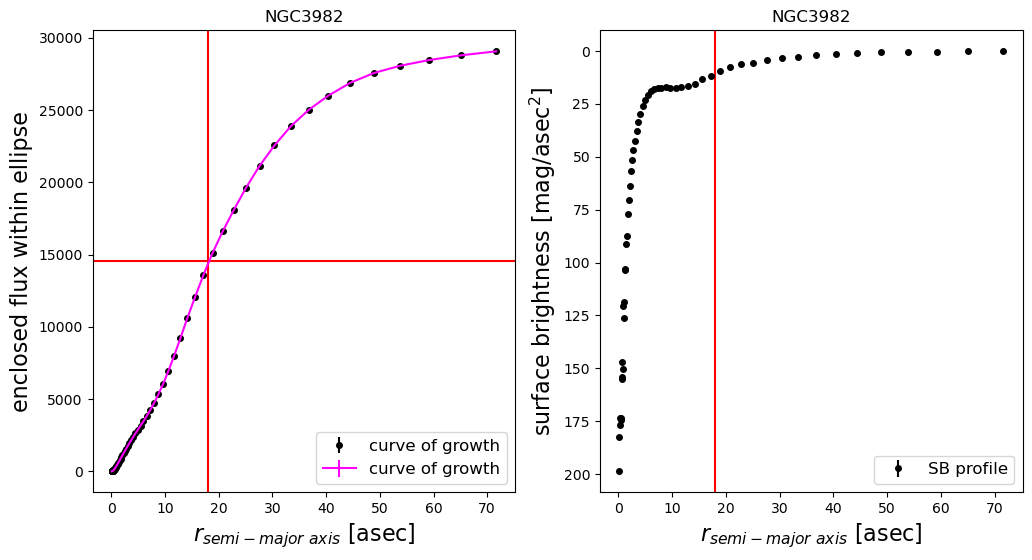

In [94]:
galname = 'NGC3982'

#we will use the isophote shape that corresponds to the average isophote values from the previous section
#xcenav[galname], ycenav[galname], epsav[galname], paav[galname]

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#print('pixscale, ',pixscale)

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
totflux = np.array([])
totflux_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * (1.-epsav[galname])
        b_in = a_in * (1.-epsav[galname])

        #[REENABLE THIS PRINT for more info]
        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((xcenav[galname],ycenav[galname]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = paav[galname])
        total_aperture = EllipticalAperture((xcenav[galname],ycenav[galname]), 
                                             a_out, b_out, theta = paav[galname])
        aperstats_ann = ApertureStats(data_bsub[galname],annulus_aperture)
        aperstats_tot = ApertureStats(data_bsub[galname],total_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats_ann.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats_ann.std
        #the number of pixels in each annulus
        numpix = aperstats_ann.sum_aper_area

        #Now do the total within each aperture
        totflux = np.append(totflux,aperstats_tot.sum)
        totflux_err = np.append(totflux_err,aperstats_tot.std)
        
        #****************************
        #your code here
        #the area of a pixel
        #pixscale above says the arcsec spanned by one pixel
        # so the area is pixscale squared with units asec^2
        pixarea = pixscale**2
        #determine the average surface brightness in mag/asec^2.
        #average surface brightness per pixel is already given as avflux, which is mag/pix
        #so (mag/pix)*(pix/asec^2) = mag/asec^2
        #pixarea is asex^2/pix
        #so we want avflux/pixarea
        sbcent = np.append(sbcent,(avflux/pixarea))
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        #uncertainty in the mean is the sample standard deviation divided by the square root of the size of the sample
        #in this case, stdflux divided by sqrt(numpix)
        #with sqrt(x) being x**(0.5)
        avflux_err = stdflux/(numpix**0.5)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, avflux_err) #I think this is all that goes here?

fig,ax = plt.subplots(1,2,figsize=(12, 6))

#plot the semi-major axis vs. magnitude
ax[1].errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax[1].invert_yaxis()

ax[1].legend(fontsize=12)

ax[1].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[1].set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
ax[1].set_title(galname)

#plot the curve of growth
ax[0].errorbar(rcent, totflux, yerr=totflux_err, 
             fmt='o', markersize=4, color='black', label='curve of growth')
ax[0].errorbar(rcent, totflux, yerr=totflux_err, 
             fmt='-', markersize=4, color='magenta', label='curve of growth')

#ax[0].axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax[0].legend(fontsize=12)

ax[0].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[0].set_ylabel('enclosed flux within ellipse',fontsize=16)
ax[0].set_title(galname)

#measure the half-light radius
#a horizontal line at half the total flux
ax[0].axhline(totflux[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
#you shoul do this using the plot you make, not using the image itself.
#Using the nearest whole number value. A more precise value would be a bit above 18.
rhalfasec[galname] = 18
ax[0].axvline(rhalfasec[galname], color='red')
print(f'the half-light radius = {rhalfasec[galname]:.3f} [asec]')

#plot the same line on the surface brightness plot
ax[1].axvline(rhalfasec[galname], color='red', label='$r_{half}$')

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
#For this first one, the innermost one does have a value
#Creating this check in case future ones do not
sb_center = 0
center_count = 0
for index in sbcent:
    if not np.isnan(index):
        sb_center = index
        break
    center_count+=1 #for verifying how far out it needed to go
print('Surface brightness at the center is ',sb_center,' [mag/asec^2]')
#print('center_count, ',center_count) #printout for testing only

#calculate and print out the surface brightness at the effective radius
#***********************
#your code here
#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = rcent - rhalfasec[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfasecind = np.argmin(abs(diff))

#print('rhalfasecind, ',rhalfasecind) #printout for testing

#we want to display the surface brightness at this index
#the list of surface brightnesses is sbcent

print('The surface brightness at half radius is ',sbcent[rhalfasecind],' [mag/asec^2]')

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here

#flux values being used for the flux graph are totflux
#the index of the center will be center_count from above
#the index of half will be rhalfasecind

#print('totflux[rhalfasecind], ',totflux[rhalfasecind]) #printouts for testing only
#print('totflux[center_count], ',totflux[center_count])

flux_rat = totflux[rhalfasecind]/totflux[center_count]
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')


### NGC 5198

the half-light radius = 19.000 [asec]
Surface brightness at the center is  248.90066075384738  [mag/asec^2]
The surface brightness at half radius is  5.068646269623013  [mag/asec^2]
flux_SB(rhalf) / flux_SB(rcent) = 886.204


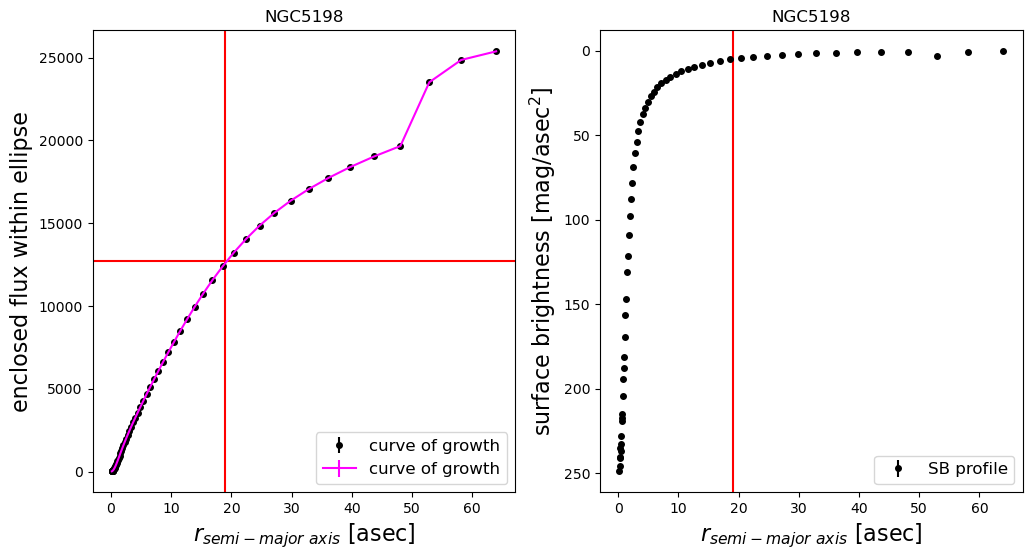

In [96]:
#everything should work exactly the same
#after manually adjusting rhalfasec
galname = 'NGC5198'

#we will use the isophote shape that corresponds to the average isophote values from the previous section
#xcenav[galname], ycenav[galname], epsav[galname], paav[galname]

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
totflux = np.array([])
totflux_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * (1.-epsav[galname])
        b_in = a_in * (1.-epsav[galname])

        #[REENABLE THIS PRINT for more info]
        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((xcenav[galname],ycenav[galname]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = paav[galname])
        total_aperture = EllipticalAperture((xcenav[galname],ycenav[galname]), 
                                             a_out, b_out, theta = paav[galname])
        aperstats_ann = ApertureStats(data_bsub[galname],annulus_aperture)
        aperstats_tot = ApertureStats(data_bsub[galname],total_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats_ann.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats_ann.std
        #the number of pixels in each annulus
        numpix = aperstats_ann.sum_aper_area

        #Now do the total within each aperture
        totflux = np.append(totflux,aperstats_tot.sum)
        totflux_err = np.append(totflux_err,aperstats_tot.std)
        
        #****************************
        #your code here
        #the area of a pixel
        #pixscale above says the arcsec spanned by one pixel
        # so the area is pixscale squared with units asec^2
        pixarea = pixscale**2
        #determine the average surface brightness in mag/asec^2.
        #average surface brightness per pixel is already given as avflux, which is mag/pix
        #so (mag/pix)*(pix/asec^2) = mag/asec^2
        #pixarea is asex^2/pix
        #so we want avflux/pixarea
        sbcent = np.append(sbcent,(avflux/pixarea))
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        #uncertainty in the mean is the sample standard deviation divided by the square root of the size of the sample
        #in this case, stdflux divided by sqrt(numpix)
        #with sqrt(x) being x**(0.5)
        avflux_err = stdflux/(numpix**0.5)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, avflux_err) #I think this is all that goes here?

fig,ax = plt.subplots(1,2,figsize=(12, 6))

#plot the semi-major axis vs. magnitude
ax[1].errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax[1].invert_yaxis()

ax[1].legend(fontsize=12)

ax[1].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[1].set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
ax[1].set_title(galname)

#plot the curve of growth
ax[0].errorbar(rcent, totflux, yerr=totflux_err, 
             fmt='o', markersize=4, color='black', label='curve of growth')
ax[0].errorbar(rcent, totflux, yerr=totflux_err, 
             fmt='-', markersize=4, color='magenta', label='curve of growth')

#ax[0].axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax[0].legend(fontsize=12)

ax[0].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[0].set_ylabel('enclosed flux within ellipse',fontsize=16)
ax[0].set_title(galname)

#measure the half-light radius
#a horizontal line at half the total flux
ax[0].axhline(totflux[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
#you shoul do this using the plot you make, not using the image itself.
rhalfasec[galname] = 19
ax[0].axvline(rhalfasec[galname], color='red')
print(f'the half-light radius = {rhalfasec[galname]:.3f} [asec]')

#plot the same line on the surface brightness plot
ax[1].axvline(rhalfasec[galname], color='red', label='$r_{half}$')

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
#For this first one, the innermost one does have a value
#Creating this check in case future ones do not
sb_center = 0
center_count = 0
for index in sbcent:
    if not np.isnan(index):
        sb_center = index
        break
    center_count+=1 #for verifying how far out it needed to go
print('Surface brightness at the center is ',sb_center,' [mag/asec^2]')
#print('center_count, ',center_count) #printout for testing only

#calculate and print out the surface brightness at the effective radius
#***********************
#your code here
#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = rcent - rhalfasec[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfasecind = np.argmin(abs(diff))

#print('rhalfasecind, ',rhalfasecind) #printout for testing

#we want to display the surface brightness at this index
#the list of surface brightnesses is sbcent

print('The surface brightness at half radius is ',sbcent[rhalfasecind],' [mag/asec^2]')

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here

#flux values being used for the flux graph are totflux
#the index of the center will be center_count from above
#the index of half will be rhalfasecind

#print('totflux[rhalfasecind], ',totflux[rhalfasecind]) #printouts for testing only
#print('totflux[center_count], ',totflux[center_count])

flux_rat = totflux[rhalfasecind]/totflux[center_count]
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')


### NGC 5985

the half-light radius = 92.000 [asec]
Surface brightness at the center is  94.12125311325173  [mag/asec^2]
The surface brightness at half radius is  1.0089623680321393  [mag/asec^2]
flux_SB(rhalf) / flux_SB(rcent) = 11512.781


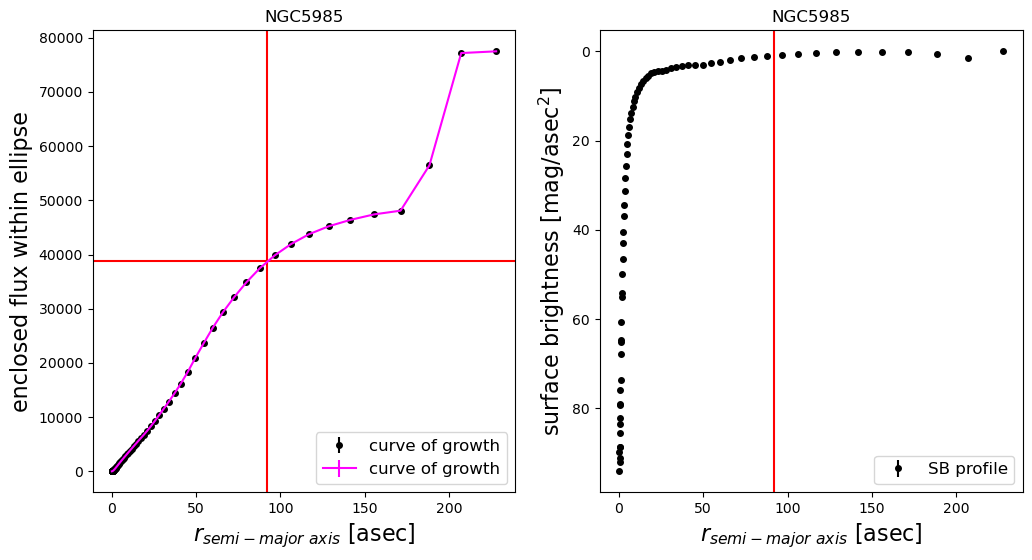

In [98]:
#everything should work exactly the same
#after manually adjusting rhalfasec
galname = 'NGC5985'

#we will use the isophote shape that corresponds to the average isophote values from the previous section
#xcenav[galname], ycenav[galname], epsav[galname], paav[galname]

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
totflux = np.array([])
totflux_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * (1.-epsav[galname])
        b_in = a_in * (1.-epsav[galname])

        #[REENABLE THIS PRINT for more info]
        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((xcenav[galname],ycenav[galname]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = paav[galname])
        total_aperture = EllipticalAperture((xcenav[galname],ycenav[galname]), 
                                             a_out, b_out, theta = paav[galname])
        aperstats_ann = ApertureStats(data_bsub[galname],annulus_aperture)
        aperstats_tot = ApertureStats(data_bsub[galname],total_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats_ann.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats_ann.std
        #the number of pixels in each annulus
        numpix = aperstats_ann.sum_aper_area

        #Now do the total within each aperture
        totflux = np.append(totflux,aperstats_tot.sum)
        totflux_err = np.append(totflux_err,aperstats_tot.std)
        
        #****************************
        #your code here
        #the area of a pixel
        #pixscale above says the arcsec spanned by one pixel
        # so the area is pixscale squared with units asec^2
        pixarea = pixscale**2
        #determine the average surface brightness in mag/asec^2.
        #average surface brightness per pixel is already given as avflux, which is mag/pix
        #so (mag/pix)*(pix/asec^2) = mag/asec^2
        #pixarea is asex^2/pix
        #so we want avflux/pixarea
        sbcent = np.append(sbcent,(avflux/pixarea))
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        #uncertainty in the mean is the sample standard deviation divided by the square root of the size of the sample
        #in this case, stdflux divided by sqrt(numpix)
        #with sqrt(x) being x**(0.5)
        avflux_err = stdflux/(numpix**0.5)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, avflux_err) #I think this is all that goes here?

fig,ax = plt.subplots(1,2,figsize=(12, 6))

#plot the semi-major axis vs. magnitude
ax[1].errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax[1].invert_yaxis()

ax[1].legend(fontsize=12)

ax[1].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[1].set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
ax[1].set_title(galname)

#plot the curve of growth
ax[0].errorbar(rcent, totflux, yerr=totflux_err, 
             fmt='o', markersize=4, color='black', label='curve of growth')
ax[0].errorbar(rcent, totflux, yerr=totflux_err, 
             fmt='-', markersize=4, color='magenta', label='curve of growth')

#ax[0].axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax[0].legend(fontsize=12)

ax[0].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[0].set_ylabel('enclosed flux within ellipse',fontsize=16)
ax[0].set_title(galname)

#measure the half-light radius
#a horizontal line at half the total flux
ax[0].axhline(totflux[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
#you shoul do this using the plot you make, not using the image itself.
rhalfasec[galname] = 92
ax[0].axvline(rhalfasec[galname], color='red')
print(f'the half-light radius = {rhalfasec[galname]:.3f} [asec]')

#plot the same line on the surface brightness plot
ax[1].axvline(rhalfasec[galname], color='red', label='$r_{half}$')

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
#For this first one, the innermost one does have a value
#Creating this check in case future ones do not
sb_center = 0
center_count = 0
for index in sbcent:
    if not np.isnan(index):
        sb_center = index
        break
    center_count+=1 #for verifying how far out it needed to go
print('Surface brightness at the center is ',sb_center,' [mag/asec^2]')
#print('center_count, ',center_count) #printout for testing only

#calculate and print out the surface brightness at the effective radius
#***********************
#your code here
#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = rcent - rhalfasec[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfasecind = np.argmin(abs(diff))

#print('rhalfasecind, ',rhalfasecind) #printout for testing

#we want to display the surface brightness at this index
#the list of surface brightnesses is sbcent

print('The surface brightness at half radius is ',sbcent[rhalfasecind],' [mag/asec^2]')

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here

#flux values being used for the flux graph are totflux
#the index of the center will be center_count from above
#the index of half will be rhalfasecind

#print('totflux[rhalfasecind], ',totflux[rhalfasecind]) #printouts for testing only
#print('totflux[center_count], ',totflux[center_count])

flux_rat = totflux[rhalfasecind]/totflux[center_count]
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')


### PGC 0997820

the half-light radius = 6.000 [asec]
Surface brightness at the center is  19.855053578631225  [mag/asec^2]
The surface brightness at half radius is  2.4549335165018746  [mag/asec^2]
flux_SB(rhalf) / flux_SB(rcent) = 560.955


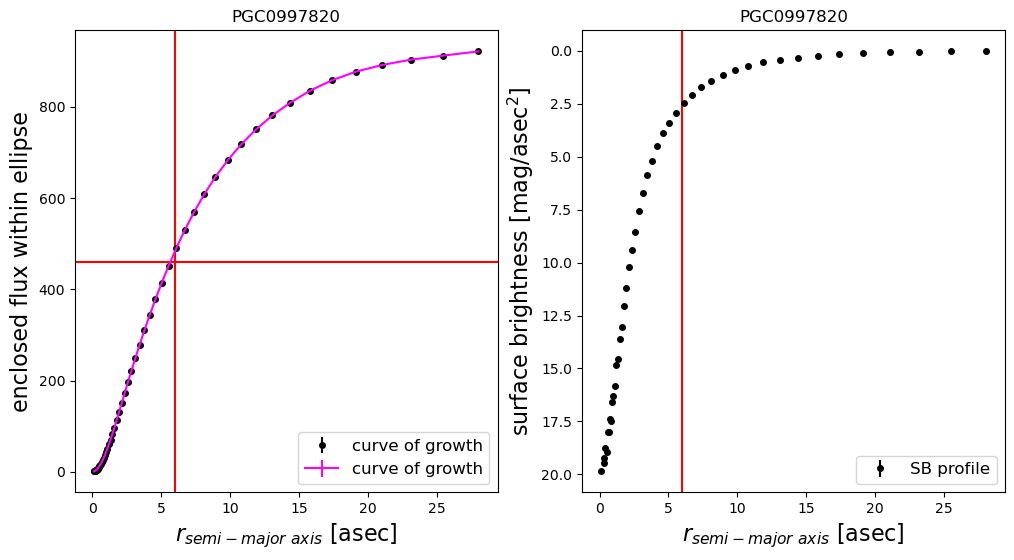

In [100]:
#everything should work exactly the same
#after manually adjusting rhalfasec
galname = 'PGC0997820'

#we will use the isophote shape that corresponds to the average isophote values from the previous section
#xcenav[galname], ycenav[galname], epsav[galname], paav[galname]

#the magnitude zeropoint of the image, such that mag = -2.5 * log(flux) + magzp
magzp = header[galname]['MAGZERO']

#The pixel scale from the header converted from degrees to asec
pixscale = header[galname]['CD2_2'] * 3600.    #in asec/pix

#Go through every aperture and measure the surface brightness between it and the next most outer isophote
#initialize arrays for surface brightness and bin center
rcent = np.array([])
sbcent = np.array([])
sbcent_err = np.array([])
totflux = np.array([])
totflux_err = np.array([])
for aindx, a_out in enumerate(isolist[galname].sma):

    #skip the first isophote because I will always compute the values between the current isophote and the previous
    if aindx==0:
        a_in = 0.01

    if aindx>0:
        #create the inner and outer minor axes from the major axes and ellipticity
        b_out = a_out * (1.-epsav[galname])
        b_in = a_in * (1.-epsav[galname])

        #[REENABLE THIS PRINT for more info]
        #print(f'a_out = {a_out:.2f}; a_in ={a_in:.2f}; b_out ={b_out:.2f}; b_in ={b_in:.2f}')
        #set up elliptical annulus using parameters at rhalf
        annulus_aperture = EllipticalAnnulus((xcenav[galname],ycenav[galname]), 
                                             a_in, a_out, b_out, b_in = b_in,
                                             theta = paav[galname])
        total_aperture = EllipticalAperture((xcenav[galname],ycenav[galname]), 
                                             a_out, b_out, theta = paav[galname])
        aperstats_ann = ApertureStats(data_bsub[galname],annulus_aperture)
        aperstats_tot = ApertureStats(data_bsub[galname],total_aperture)
        a_in = a_out

        #the central radius of each annulus in asec.  I'm appending each central radius to the existing array
        rcent = np.append(rcent, (a_in + a_out) / 2.*pixscale)
        #the average pixel flux within each annulus
        avflux = aperstats_ann.mean
        #the standard deviation of the pixel values within each annulus
        stdflux = aperstats_ann.std
        #the number of pixels in each annulus
        numpix = aperstats_ann.sum_aper_area

        #Now do the total within each aperture
        totflux = np.append(totflux,aperstats_tot.sum)
        totflux_err = np.append(totflux_err,aperstats_tot.std)
        
        #****************************
        #your code here
        #the area of a pixel
        #pixscale above says the arcsec spanned by one pixel
        # so the area is pixscale squared with units asec^2
        pixarea = pixscale**2
        #determine the average surface brightness in mag/asec^2.
        #average surface brightness per pixel is already given as avflux, which is mag/pix
        #so (mag/pix)*(pix/asec^2) = mag/asec^2
        #pixarea is asex^2/pix
        #so we want avflux/pixarea
        sbcent = np.append(sbcent,(avflux/pixarea))
        # the uncertainty in the mean flux (this is not the standard deviation of all the pixels in the aperture).  
        # Check back to Homework 1
        #uncertainty in the mean is the sample standard deviation divided by the square root of the size of the sample
        #in this case, stdflux divided by sqrt(numpix)
        #with sqrt(x) being x**(0.5)
        avflux_err = stdflux/(numpix**0.5)
        avflux_err = avflux_err * u.pix   #this gets rid of the units on the flux error so that the next part works
        sbcent_err = np.append(sbcent_err, avflux_err) #I think this is all that goes here?

fig,ax = plt.subplots(1,2,figsize=(12, 6))

#plot the semi-major axis vs. magnitude
ax[1].errorbar(rcent, sbcent, yerr=sbcent_err, 
             fmt='o', markersize=4, color='black', label='SB profile')
ax[1].invert_yaxis()

ax[1].legend(fontsize=12)

ax[1].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[1].set_ylabel('surface brightness [mag/asec$^2$]',fontsize=16)
ax[1].set_title(galname)

#plot the curve of growth
ax[0].errorbar(rcent, totflux, yerr=totflux_err, 
             fmt='o', markersize=4, color='black', label='curve of growth')
ax[0].errorbar(rcent, totflux, yerr=totflux_err, 
             fmt='-', markersize=4, color='magenta', label='curve of growth')

#ax[0].axvline(rhalfasec[galname], color='red', label='$r_{half}$')
ax[0].legend(fontsize=12)

ax[0].set_xlabel('$r_{semi-major~axis}$ [asec]',fontsize=16)
ax[0].set_ylabel('enclosed flux within ellipse',fontsize=16)
ax[0].set_title(galname)

#measure the half-light radius
#a horizontal line at half the total flux
ax[0].axhline(totflux[-1]/2., color='red')

#a vertical line at half the total flux
#*************************
#You will need to adjust rhalfpix by eye to get the radius that encompasses half the light.
#you shoul do this using the plot you make, not using the image itself.
#6 isn't super close but there's few enough data points that there's probably no need to be more precise
rhalfasec[galname] = 6
ax[0].axvline(rhalfasec[galname], color='red')
print(f'the half-light radius = {rhalfasec[galname]:.3f} [asec]')

#plot the same line on the surface brightness plot
ax[1].axvline(rhalfasec[galname], color='red', label='$r_{half}$')

#calculate and print the surface brightness somewhere within 3 arcsec from the center.  
#Note that some of the inner values have NaNs because the isophote fitting failed there.  
#Just keep going out in index until you get a valid value
#***********************
#your code here
#For this first one, the innermost one does have a value
#Creating this check in case future ones do not
sb_center = 0
center_count = 0
for index in sbcent:
    if not np.isnan(index):
        sb_center = index
        break
    center_count+=1 #for verifying how far out it needed to go
print('Surface brightness at the center is ',sb_center,' [mag/asec^2]')
#print('center_count, ',center_count) #printout for testing only

#calculate and print out the surface brightness at the effective radius
#***********************
#your code here
#find the isophote that best corresponds to the half-light radius
#We will do this by computing the difference between the half-light radius
#and the semi-major axis of each isophote.  
diff = rcent - rhalfasec[galname]

#this returns the index of the isophote that is closes to the half-light radius
#We use this to set the ellipticity and PA of the isophotes
rhalfasecind = np.argmin(abs(diff))

#print('rhalfasecind, ',rhalfasecind) #printout for testing

#we want to display the surface brightness at this index
#the list of surface brightnesses is sbcent

print('The surface brightness at half radius is ',sbcent[rhalfasecind],' [mag/asec^2]')

#calculate and print out the ratio of the **flux** surface brightness between the center and at r_half
#***********************
#your code here

#flux values being used for the flux graph are totflux
#the index of the center will be center_count from above
#the index of half will be rhalfasecind

#print('totflux[rhalfasecind], ',totflux[rhalfasecind]) #printouts for testing only
#print('totflux[center_count], ',totflux[center_count])

flux_rat = totflux[rhalfasecind]/totflux[center_count]
print(f'flux_SB(rhalf) / flux_SB(rcent) = {flux_rat:.3f}')


**Question** For the galaxies above, answer in words written below each bullet:
* For each galaxy how the half-light compares to the visible extent of the galaxy using what you see in the displayed images or in ds9?

For each of these comparisons, I created a region in DS9 that's a circle with the half-light radius and compared it to the originally drawn region.

NGC 3982: The half-light radius is pretty close to the originally drawn bounds of the galaxy. Some features are still visible outside it - mainly ones that are contained by the more elliptical drawn region.

NGC 5198: The half-light radius is far larger than the manually drawn galaxy boundaries. Adjusting the scale in DS9, the light severely diminishes by the time it reaches the half-light radius.

NGC 5985: It's difficult to compare these two due to the strong ellipticity of this galaxy, but the half-light radius is generally larger than the manually drawn galaxy bounds. The half-light radius extends well beyond clear galaxy features in most dimensions.

PGC 0997820: The half-light radius verey closely matches the manually drawn galaxy bounds.


* For each galaxy, we need to establish the radius within which nearly all of the flux is contained.  This point can be determined by looking at how the curve of growth changes with radius and is not necessarily the largest radius to which you plot.  which feature of the curve of growth curves you plotted tells you where the radius is that contains most of the flux and whether you can evern robustly determine this radius?

In the surface brightness graph, most galaxies have a sharp turn-off where it goes much more horizontal, indicating the flux is not substantially increasing with radius. This is a good place to draw the line indicating the extent of the strong influence of the galaxy. NGC 3982 and NGC 5985 have a very strong such hook.

NGC 5198 and especially PGC 0997820 have a more gentle curve. It's reasonable to estimate a plateau point for NGC 5198 but it's not reasonable to establish such a boundary for PGC 0997820, at least with the information worked with here.



* For each galaxy, use imexam to measure the FWHM of the image using stars in the image.  Then quantify how your half-light radius for each galaxy compares to the FWHM.  Do you think that the half-light radius is big enough to not be influenced by smearing of the image by the PSF.  This needs to be given for each galaxy.

Due to imexam not working, the FWHM is assumed to be 4 pixels for each image.

The pixel scale is 0.262 asec per pixel. This means the FWHM of the images is about 1 arcsec.

For NGC 5985, this value is absolutely negligible compared to its half-light radius of 92 asec.

NGC 3982 and NGC 5198 have a half-light radius of 18 and 19 arcsec respectively. At about 5%, the PSF probably has a small impact on the exact value of the half-light radius, but is unimportant in this specific analysis due to the limited number of isophotes being graphed and the half-light radius being assigned as a whole number.

For PGC 0997820, PSF absolutely has an effect on the half-light radius given that the latter is only 6 arcsec. This telescope cannot be used to determine the exact boundaries of this galaxy due to the galaxy's small visual size.



**Question** If the goal of measuring the half-light radius is to measure the distribution of light from the galaxy and not any other sources on the image, what do you think you can do in order to minimize the effect of other sources in the image on this measurment.  

**put answer here**

As we've seen in this analysis, bright nearby objects noticeably skew the freely drawn ellipses. They should also have a strong effect on the flux/brightness being considered by the constrained isophotes. The most direct way to minimize the impact of these other sources would be to subtract them from the image. Each source near the galaxy would need analyzed and compared to the the background around the source and/or the flux at a point opposite the source respective to the more inner ellipses. If you replace the source values with the values near the source, it would result in a cleaner, smoother galaxy as if that source weren't there. This process would be far from perfect due to its reliance on estimation, but it would reduce the impact of the sources more than leaving them untouched or replacing them with something like the full image background.

## Problem 5 - Describe the ratio in surface brightness between the center and outskirts, as well as the other points below: (10 points)
* Are there differences in the profiles between ellipticals and spirals?
* Does the behavior of the light profile differ inside and outside of the half-light radius?  
* Which galaxies have light profiles consistent with being exponential, and in what part of the profiles? You must describe why they look like exponentials.  Note that not all galaxies have exponential profiles, but some do.
* For the galaxies consistent with an exponential profile, what is exponential scale length of the disk.  You must show all your calculations.

**answer goes here**

Ultimately there are few differences between the elliptical and spiral galaxies. One interesting difference that doesn't come across in the graphs is the asymmetry and spiraling of the isophotes in the spiral galaxies, as discussed previously. Most notably, the spiral galaxies have a sharper angle in the surface brightness graph, indicating a better-defined edge of the galaxy; this seems appropriate, considering that when visually studying the galaxies, the spiral galaxies have a clearer border in the form of arms while the elliptical galaxies spread out more smoothly.

The half-light radius does not match any particular change in the light profile. For PGC 0997820, it occurs at approximately the halfway point of the main surface brightness curve; for all other galaxies, it occurs well beyond that point, indicating no strong correlation between the half-light radius and a particular physical feature. It could potentially be said that the surface brightness grows exponentially inside the half-light radius and linearly or even not at all outside it, but that switch happens far enough within the half-light radius that I wouldn't call it a strong correlation.

An exponential light profile has a linear appearance on a brightness/radius graph. The two elliptical galaxies maintain a smooth curve throughout and do not have an exponential profile for any significant length. The two spiral galaxies, however, are exponential in their outer regions, beginning a bit before the half-light radius and extending for the rest of the plotted area.

The equation for exponential scale length is I(R) = I(0) e^(-R/h), where h is the scale length. This can be rearranged into h = -R/ln(I(R)/I(0)). This is easy to work out as we've already calculated I(R)/I(0) for R being the half-light radius for every galaxy.

NGC 3982: R = 18 asec ; I(R)/I(0) = 1580.344 ; h = 2.44 asec.

NGC 5985: R = 92 asec; I(R)/I(0) = 11512.781 ; h = 9.84 asec.